# Research for low-contrast sample

In this notebook, I am testing the methods from skimage4ComparisonWOpenCV for the case of low-contrast images. <br>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def sideBside(img1, img2, ttl1='Original image', ttl2='Result'):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axes.ravel()

    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(ttl1)

    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(ttl2)

    for a in ax:
        a.axis('off')

    plt.show()

In [3]:

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import histogram
from skimage import filters as flt


In [5]:
fname = '../data/interim/1B-B1N_10x.jpg' #NICE
img = io.imread(fname)
# img_small = resize(img, (500, 500), anti_aliasing=True)


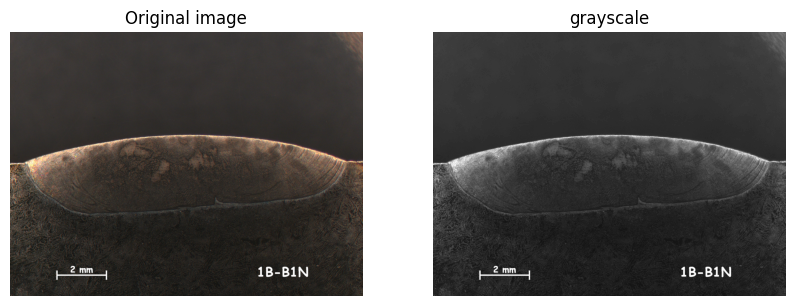

In [8]:
gray = rgb2gray(img)
sideBside(img, gray, ttl2='grayscale')

plt.show()

Let's look at the histogram

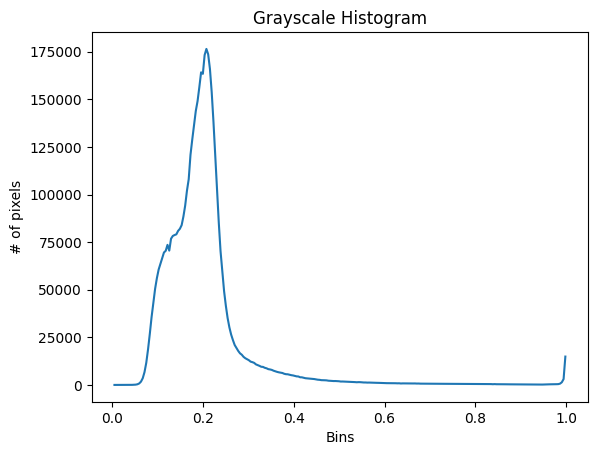

In [9]:
hist, hist_centers = histogram(gray, nbins=256)
plt.plot(hist_centers, hist)
plt.title('Grayscale Histogram')
plt.xlabel('Bins')
plt.ylabel('# of pixels')

plt.show()

In [12]:
from skimage.color import rgb2hsv
sample_hsv = rgb2hsv(img) 

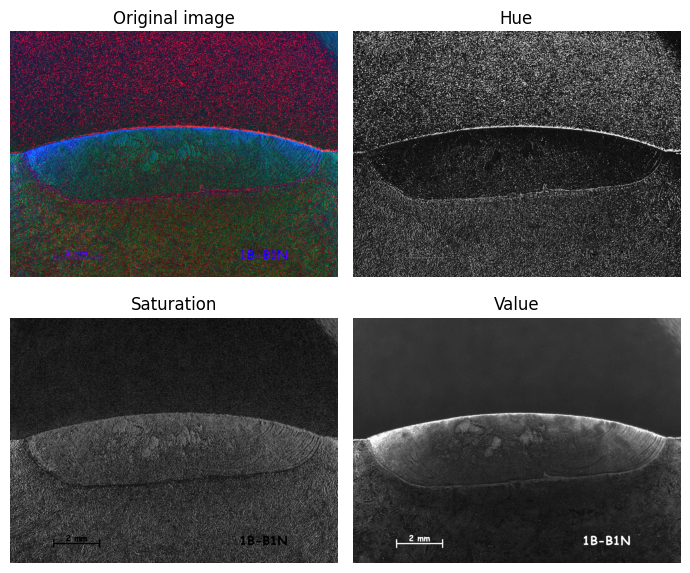

In [13]:
null = np.zeros_like(sample_hsv[:, :, 0])
hsv_h = np.stack((sample_hsv[:, :, 0], null, null), axis=-1)
hsv_s = np.stack((null, sample_hsv[:, :, 1], null), axis=-1)
hsv_v = np.stack((null, null, sample_hsv[:, :, 2]), axis=-1)
hsv_h_gr = rgb2gray(hsv_h)
hsv_s_gr = rgb2gray(hsv_s)
hsv_v_gr = rgb2gray(hsv_v)


# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sample_hsv)
ax[0].set_title("Original image")

ax[1].imshow(hsv_h_gr, cmap='gray')
ax[1].set_title("Hue")

ax[2].imshow(hsv_s_gr, cmap='gray')
ax[2].set_title("Saturation")  # Note that there is no Eosin stain in this image

ax[3].imshow(hsv_v_gr, cmap='gray')
ax[3].set_title("Value")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

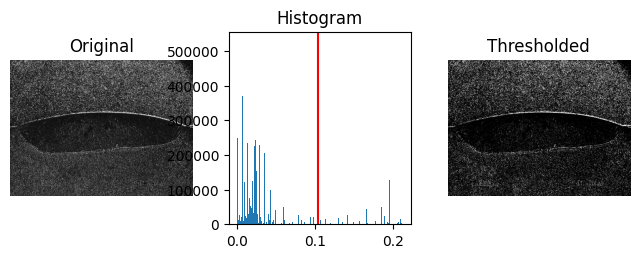

In [35]:
from skimage.filters import threshold_otsu, threshold_mean

image = hsv_h_gr
thresh = threshold_otsu(image)
# thresh = threshold_mean(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Applying Theshold

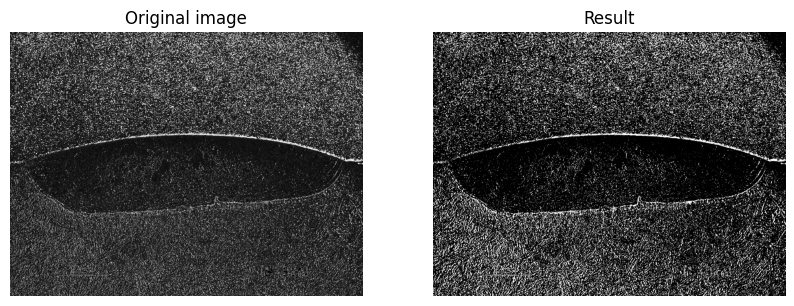

In [30]:
binary = hsv_h_gr > (.05)

sideBside(hsv_h_gr, binary)


Apply a Gaussian blur to the image to reduce noise. <br>
**Note:** Sarah added some parameters that are different. 

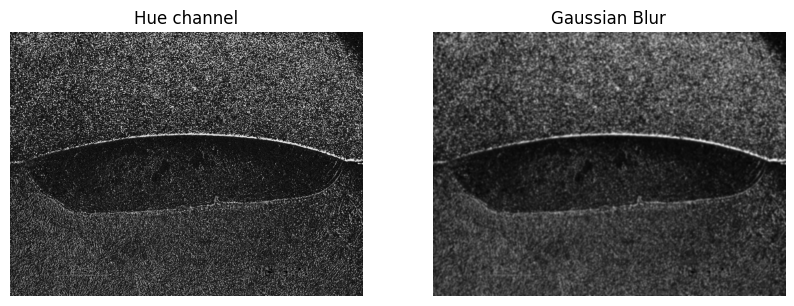

In [25]:
blurred_image = flt.gaussian(hsv_h_gr, sigma=5)

sideBside(hsv_h_gr, blurred_image, ttl1='Hue channel', ttl2='Gaussian Blur')

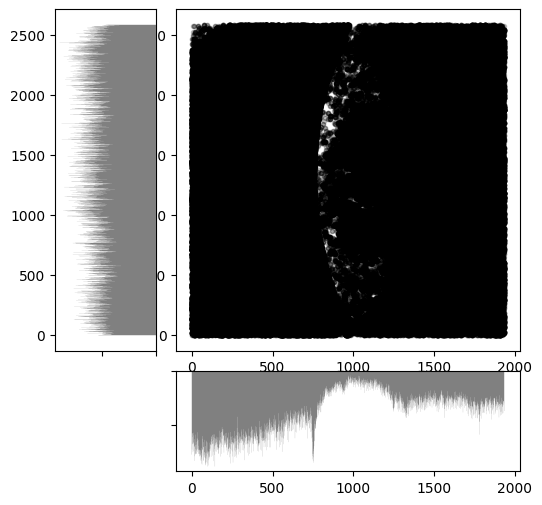

In [39]:

x, y = np.where(binary)

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, binary.shape[0], histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()
# x_hist.set_yscale('log')

y_hist.hist(y, binary.shape[1], histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

Apply Canny edge detector to the blurred image. the imputs 25, 75 are guided by the histogram of insensities

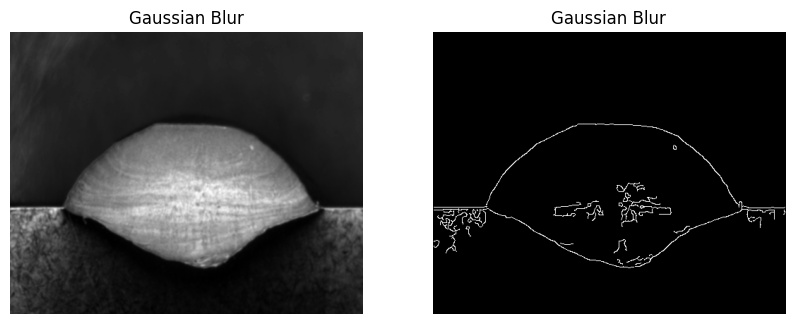

In [51]:
from skimage.feature import canny
edges_image = canny(blurred_image, low_threshold=25/255, high_threshold=75/255)
sideBside(blurred_image, edges_image, ttl1='Gaussian Blur', ttl2='Gaussian Blur')

## Find contours

45 contour(s) found!


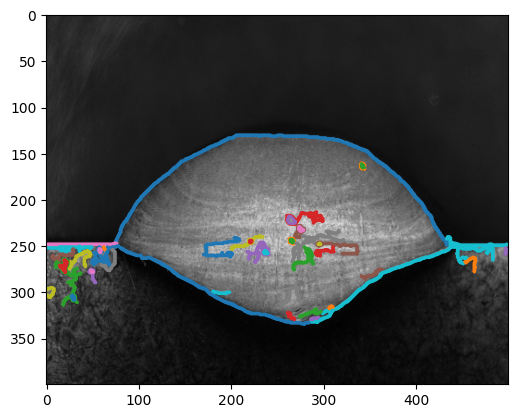

In [28]:
from skimage.measure import find_contours


contours = find_contours(edges_image, fully_connected='high')
print(f'{len(contours)} contour(s) found!')


fig, ax = plt.subplots()
ax.imshow(gray, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)


Plotting the longest edge.

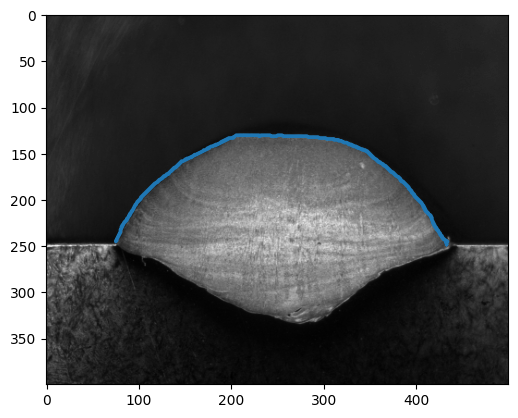

In [37]:
fig, ax = plt.subplots()
ax.imshow(gray, cmap=plt.cm.gray)

ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
plt.show()

Plotting the 3 longest edges.

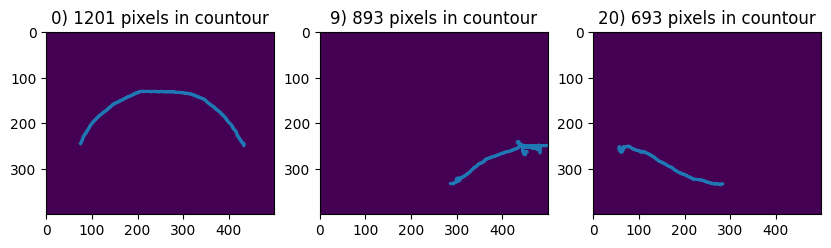

In [61]:

# --- Create a blank image
mask = np.zeros(gray.shape)

pixels_in_contour = []

fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()
i=0

minLength = 500

#--- Find contours
for j, contour in enumerate(contours): 
   if contour.shape[0] > minLength:
      ax[i].imshow(mask)
      ax[i].plot(contour[:, 1], contour[:, 0], linewidth=2)
      ax[i].set_title('{}) {} pixels in countour'.format(j, contour.shape[0]))
      i = i+1


Concatenating the three longest contours

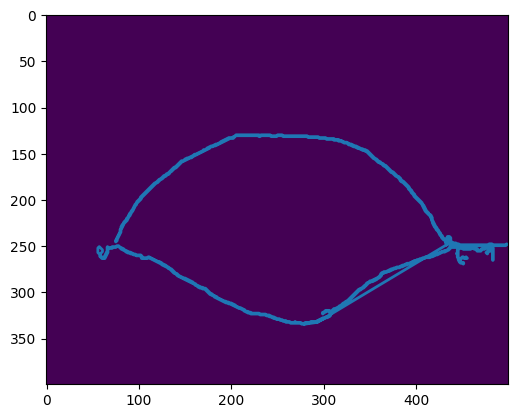

In [65]:
closedContour = np.concatenate([contours[0], contours[9], contours[20]])
plt.imshow(mask)
plt.plot(closedContour[:, 1], closedContour[:, 0], linewidth=2)
plt.show()

## Hough lines

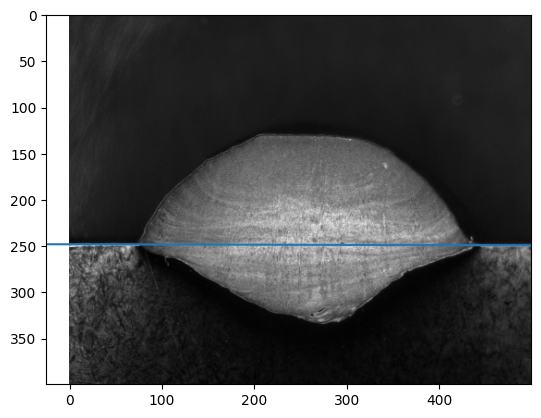

In [85]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line as draw_line

plt.imshow(gray, cmap=plt.cm.gray)

# Set a precision.
angleRange = [np.pi * 3/8, np.pi * 5/8]
tested_angles = np.linspace(angleRange[0], angleRange[1], 360, endpoint=False)
h, theta, d = hough_line(edges_image, theta=tested_angles)

# for angle in angleRange:
#     plt.axline((0, 0), slope=np.tan(angle + np.pi/2), color='r')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=1)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.show()

## Testing histogram profiling

Using profile plots we can extract the ROI of the weld and work on a more confined region of the image.

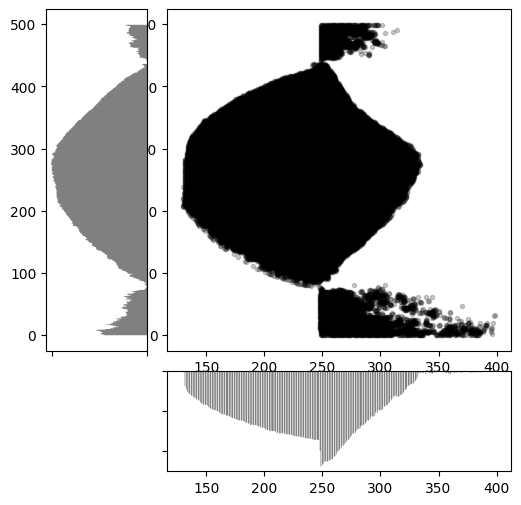

In [102]:

x, y = np.where(binary)

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, binary.shape[0], histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, binary.shape[1], histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()